# VGG-16 model:

**version check:**

In [1]:
import tensorflow as tf
print("using tensorflow: " +tf.__version__)
import keras
print("using keras: " +keras.__version__)

using tensorflow: 1.11.0-rc1


Using TensorFlow backend.


using keras: 2.2.4


In [2]:
#necessary imports

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
from glob import glob
from matplotlib.patches import Rectangle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras_preprocessing.image as KPImage
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input #VGG-16 model imports

det_class_path = '../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'
box_path = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
train_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'

**Preparing the dataset**

In [4]:
det_class_df = pd.read_csv(det_class_path)
box_df = pd.read_csv(box_path)

#merge the datasets
comb_box_df = pd.merge(box_df, det_class_df, how='inner', on='patientId')
comb_box_df = pd.concat([box_df, det_class_df.drop('patientId',1)], 1)

#finding total number of boxes for each image
box_df = comb_box_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_box_df, box_df, on='patientId')

#final dataset
image_df = pd.DataFrame({'path': glob(os.path.join(train_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
image_box_df = pd.merge(comb_box_df, image_df, on='patientId',how='left').sort_values('patientId')
print(image_box_df.shape[0], 'image bounding boxes')
image_box_df.head(5)

26684 images found
30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...


In [5]:
# labels in one hot encoding format
class_enc = LabelEncoder()
image_box_df['class_idx'] = class_enc.fit_transform(image_box_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_box_df['class_vec'] = oh_enc.fit_transform(image_box_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_box_df.sample(5)

,patientId,x,y,width,height,Target,class,boxes,path,class_idx,class_vec
6372,4e6393b9-1b25-48cc-af0c-454e0df251ff,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...,1,"[0.0, 1.0, 0.0]"
26903,ef76af54-ff7a-483f-854f-3d8527e720ef,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...,2,"[0.0, 0.0, 1.0]"
10122,6ca9f96b-f164-4022-8c4d-28eed6214c4f,211.0,557.0,131.0,155.0,1,Lung Opacity,1,../input/rsna-pneumonia-detection-challenge/st...,0,"[1.0, 0.0, 0.0]"
21561,c3ed4cdc-183a-4b8f-a51f-d915d912abab,164.0,617.0,259.0,195.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...,0,"[1.0, 0.0, 0.0]"
2912,34e84fe0-d532-47ef-af4f-250f9ef1c020,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...,2,"[0.0, 0.0, 1.0]"


# Modelling

In [6]:
# params for the VGG-16 model
BASE_MODEL= 'VGG16'
IMG_SIZE = (384, 384)
BATCH_SIZE = 24 
DENSE_COUNT = 128 
DROPOUT = 0.25 
LEARN_RATE = 1e-4
TRAIN_SAMPLES = 8000
TEST_SAMPLES = 800
USE_ATTN = False

# Split into Training and Validation

In [7]:
image_df = image_box_df.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(20013, 11) training data
(6671, 11) validation data


## Balance Training Set

7998 new training size


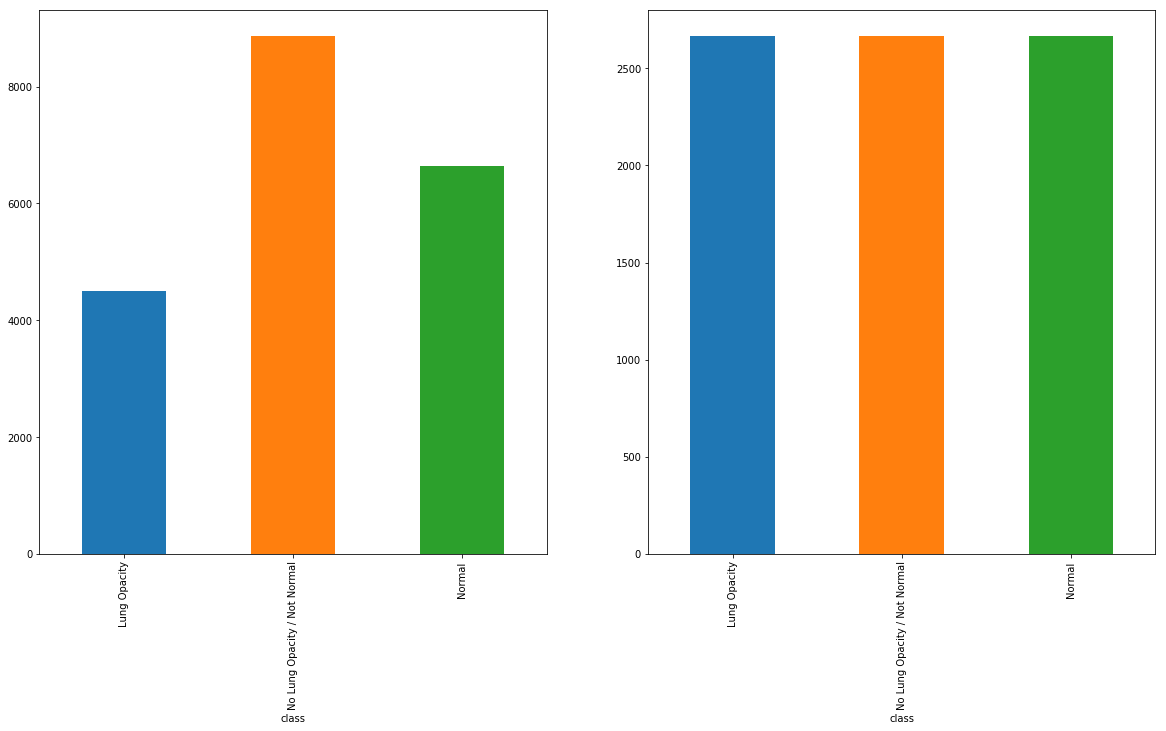

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

**Keras Image Transplantation**

In [9]:
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

## Data Augmentation

In [10]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',seed = seed,**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [12]:
train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

valid_gen = flow_from_dataframe(img_gen, valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256)
# used a fixed dataset for evaluating the algorithm
valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = TEST_SAMPLES))

Found 0 images belonging to 0 classes.
Reinserting dataframe: 7998 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6671 images


(24, 384, 384, 3) (24, 3)


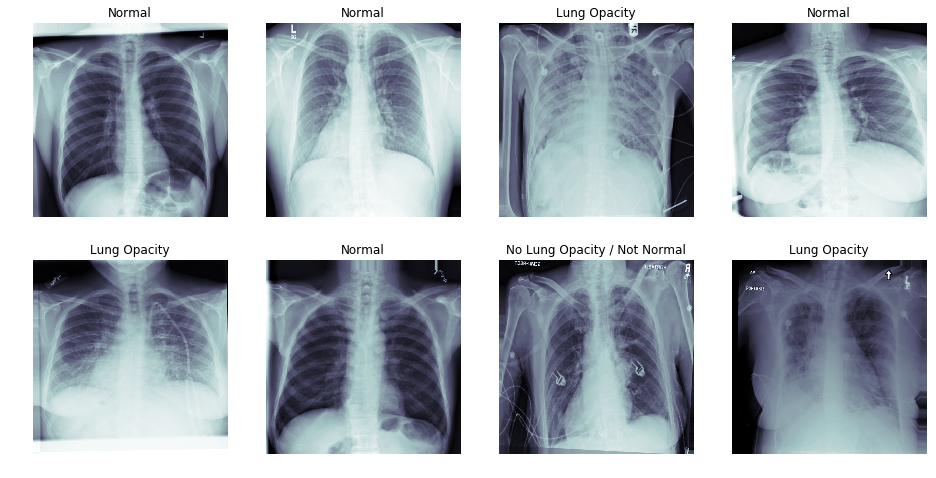

In [13]:
#showing the augmented data
t_x, t_y = next(train_gen)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % class_enc.classes_[np.argmax(c_y)])
    c_ax.axis('off')

# VGG-16 model

In [14]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


## Model Supplements
Here we add a few other layers to the model to make it better suited for the classification problem. 

In [15]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 12, 12, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 512)       2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65536     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

In [16]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 12, 12, 512)       14714688  
_________________________________________________________________
trained_model (Model)        (None, 3)                 68483     
Total params: 14,783,171
Trainable params: 67,203
Non-trainable params: 14,715,968
_________________________________________________________________


In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1062: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [18]:
train_gen.batch_size = BATCH_SIZE
pneu_model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                         validation_data=(valid_X, valid_Y), 
                         epochs=15, 
                         callbacks=callbacks_list,
                         workers=2)

Epoch 1/15
333/333 [==============================] - 401s 1s/step - loss: 1.0485 - categorical_accuracy: 0.5078 - val_loss: 0.8549 - val_categorical_accuracy: 0.5900

Epoch 00001: val_loss improved from inf to 0.85490, saving model to lung_opacity_weights.best.hdf5
Epoch 2/15
333/333 [==============================] - 374s 1s/step - loss: 0.8982 - categorical_accuracy: 0.5848 - val_loss: 0.8007 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 0.85490 to 0.80069, saving model to lung_opacity_weights.best.hdf5
Epoch 3/15
333/333 [==============================] - 388s 1s/step - loss: 0.8547 - categorical_accuracy: 0.6011 - val_loss: 0.7764 - val_categorical_accuracy: 0.6388

Epoch 00003: val_loss improved from 0.80069 to 0.77640, saving model to lung_opacity_weights.best.hdf5
Epoch 4/15
333/333 [==============================] - 387s 1s/step - loss: 0.8260 - categorical_accuracy: 0.6149 - val_loss: 0.7706 - val_categorical_accuracy: 0.6425

Epoch 00004: val_loss i

In [19]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

#validation
pred_Y = pneu_model.predict(valid_X, batch_size = BATCH_SIZE, verbose = True)

800/800 [==============================] - 8s 10ms/step


## Results

                              precision    recall  f1-score   support

                Lung Opacity       0.50      0.71      0.59       172
No Lung Opacity / Not Normal       0.75      0.50      0.60       362
                      Normal       0.73      0.87      0.79       266

                 avg / total       0.69      0.67      0.66       800



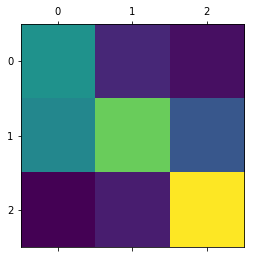

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

In [21]:
#test images
from glob import glob
sub_img_df = pd.DataFrame({'path': 
              glob('../input/rsna-pneumonia-detection-challenge/stage_2_test_images/*.dcm')})
sub_img_df['patientId'] = sub_img_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
sub_img_df.sample(3)

,path,patientId
2852,../input/rsna-pneumonia-detection-challenge/st...,207aa3ce-48b1-46af-98b8-c8905b145b3b
2562,../input/rsna-pneumonia-detection-challenge/st...,1eb1be4c-db1d-4b3a-80f1-e80a65a177b7
616,../input/rsna-pneumonia-detection-challenge/st...,1a0ca228-5501-49f8-85e6-c5e66ecd2d74


In [22]:
submission_gen = flow_from_dataframe(img_gen, 
                                     sub_img_df, 
                             path_col = 'path',
                            y_col = 'patientId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE,
                                    shuffle=False)

Found 0 images belonging to 0 classes.
Reinserting dataframe: 3000 images


### Prediction for test images

In [23]:
from tqdm import tqdm
sub_steps = 2*sub_img_df.shape[0]//BATCH_SIZE
out_ids, out_vec = [], []
for _, (t_x, t_y) in zip(tqdm(range(sub_steps)), submission_gen):
    out_vec += [pneu_model.predict(t_x)]
    out_ids += [t_y]
out_vec = np.concatenate(out_vec, 0)
out_ids = np.concatenate(out_ids, 0)

100%|██████████| 250/250 [05:08<00:00,  1.21s/it]


,patientId,Lung Opacity,No Lung Opacity / Not Normal,Normal
2201,29048813-5b20-4aba-bfcb-8eed053e3e53,0.010701,0.085108,0.904191
2965,c1863155-7189-4ff6-864b-6c661f7d625f,0.037260,0.115097,0.847643
2578,2dcb24a1-d06f-40de-80ba-20e44f233395,0.177162,0.523633,0.299204


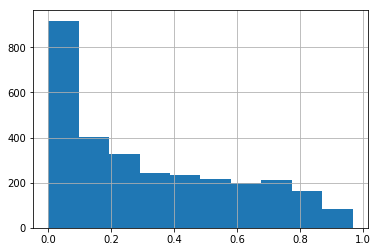

In [25]:
pred_df = pd.DataFrame(out_vec, columns=class_enc.classes_)
pred_df['patientId'] = out_ids
pred_avg_df = pred_df.groupby('patientId').agg('mean').reset_index()
pred_avg_df['Lung Opacity'].hist()
pred_avg_df.to_csv('image_level_class_probs.csv', index=False)
pred_avg_df.sample(3)

In [26]:
#prediction using 'lung opacity' as confidence metric
pred_avg_df['PredictionString'] = pred_avg_df['Lung Opacity'].map(lambda x: ('%2.2f 0 0 1024 1024' % x) if x>0.5 else '')
pred_avg_df[['patientId', 'PredictionString']].to_csv('submission.csv', index=False)